# ENUNCIADO

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en
`Material_TPs/TP3/images` a partir del template `Material_TPs/TP3/template`.

1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen `coca_multi.png` con el mismo témplate del item 2
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección

In [96]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [97]:
%cd /content/drive/MyDrive/EIA-UBA/Bimestre3/VC1/TP3

/content/drive/MyDrive/EIA-UBA/Bimestre3/VC1/TP3


In [98]:
!pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [99]:
%matplotlib inline

# OpenCV-Python utiliza NumPy para el manejo de imágenes
import numpy as np
# cv2 es el módulo python para acceder a OpenCV 
import cv2 as cv
# Usamos las poderosas herramientas de graficación de matplotlib para mostrar imágenes, perfiles, histogramas, etc
import matplotlib.pyplot as plt
# Herramienta para navegar en el contenido de carpetas
import os
import imutils

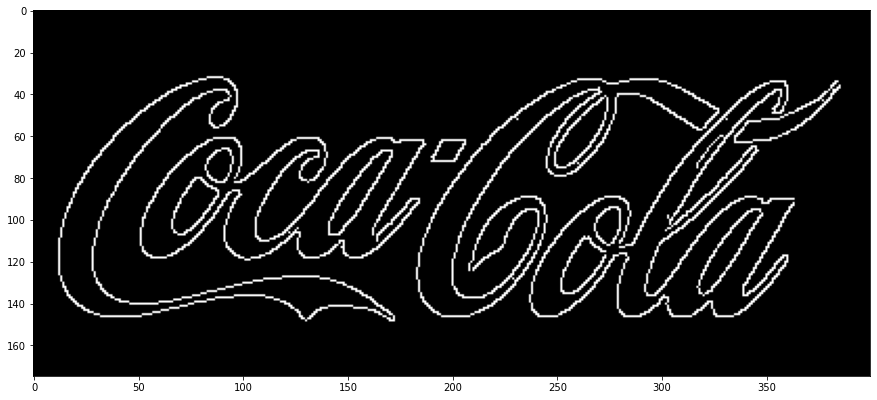

In [100]:
# Visualizo template

fileName = './template/pattern.png'
template = cv.imread(fileName, 0)
template = cv.Canny(template, 50, 200)
plt.figure(figsize=(15,15))
plt.imshow(template, cmap='gray')
plt.show()

In [101]:
tW, tH = template.shape[::-1]
print('Tamaño del template:', str(tW), 'x', str(tH))

Tamaño del template: 400 x 175


Tamaño de imagen logo_1.png :  687 x 450
Tamaño de imagen COCA-COLA-LOGO.jpg :  1389 x 1389
Tamaño de imagen coca_logo_2.png :  233 x 363
Tamaño de imagen coca_retro_1.png :  715 x 493
Tamaño de imagen coca_retro_2.png :  715 x 429
Tamaño de imagen coca_logo_1.png :  207 x 500


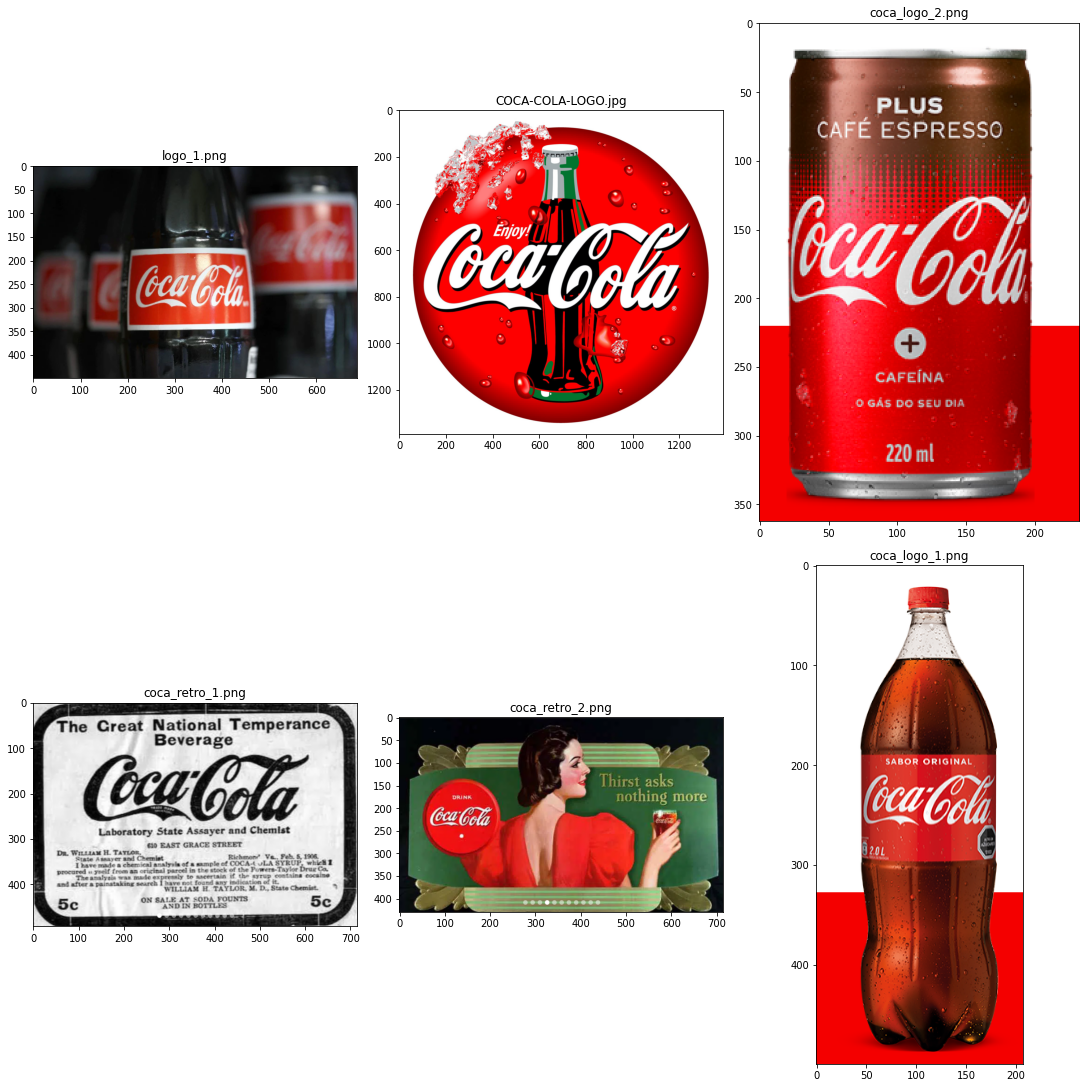

In [102]:
# Visualizo imagenes donde se buscará el patrón

directory = './images/'
fileNames = os.listdir(directory)
fileNames.remove('coca_multi.png')

IMG_GRAY, IMG_RGB = [], []
cont = 0
fig, axs = plt.subplots(2, 3, constrained_layout=True, figsize=(15,15))
for i in range(2):
  for j in range(3):
    figurePath = directory+fileNames[cont]
    img = cv.imread(figurePath)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    IMG_GRAY.append(img_gray)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    IMG_RGB.append(img_rgb)
    imgW, imgH = img_gray.shape[::-1]
    print('Tamaño de imagen', fileNames[cont], ': ', str(imgW), 'x', str(imgH))
    axs[i, j].imshow(img_rgb)
    axs[i, j].set_title(fileNames[cont])
    cont += 1

In [103]:
# Observo la longitud aparente (en píxeles) de los logos en las imagenes 
logo_sizes = [250, 1100, 180, 500, 140, 130]

## Item 1: obtención del logo en cada imagen sin falsos positivos

In [104]:
# Función para modificar tamaño de la imagen
def scale_size(img, template, logoW_img):

  logoW_temp, _ = template.shape[::-1]
  img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  imgW, imgH = img_gray.shape[::-1]

  if logoW_img<logoW_temp:
    # Rescalamiento de imagen  
    newWidth = logoW_temp*imgW/logoW_img
    img_out = imutils.resize(img, width=int(newWidth))
    return img_out, template
  else:
    # Rescalamiento del template
    template_out = imutils.resize(template, width=int(logoW_img))
    return img, template_out

In [105]:
# Función para plotear la imagen donde buscar el logo y template
def image_vs_template(img, fileName, template):
  fig, axs = plt.subplots(1, 2, figsize=(15,15))
  axs[0].imshow(img)
  axs[0].set_title('Imagen: ' + fileName)

  axs[1].imshow(template, cmap='gray')
  axs[1].set_title('Matching Result')

In [146]:
# Función para encontrar template dentro de una imagen
def findTemplate(img, fileName, template, methods):

  tW, tH = template.shape[::-1]
  fig = plt.figure(constrained_layout=True, figsize=(15,15))
  #fig.set_figwidth(20)
  fig.suptitle('Figura: '+fileName, fontsize=16, fontweight='bold')
  subfigs = fig.subfigures(len(methods))

  for i, meth in enumerate(methods):
  
    # Hago una copia de la imagen porque ciclo a ciclo le dibujo rectángulos
    img_salida = img.copy()
    img_gray = cv.cvtColor(img_salida, cv.COLOR_BGR2GRAY)
    img_Canny = cv.Canny(img_salida, 100, 200)
    method = eval(meth)
        
    # Aplicamos la coincidencia de patrones
    #--------------------------------------
    res = cv.matchTemplate(img_Canny, template, method)
        
    # Encontramos los valores máximos y mínimos
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
        
    # Si el método es TM_SQDIFF o TM_SQDIFF_NORMED, tomamos el mínimo
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
        if 'NORMED' in meth:
          confidence = res[top_left[1]][top_left[0]]
        else:
          confidence = max_val/(max_val+np.abs(min_val))
        
    # Marcamos el lugar donde lo haya encontrado
    #----------------------------------------
    bottom_right = (top_left[0] + tW, top_left[1] + tH)
    cv.rectangle(img_salida, top_left, bottom_right, (0, 0, 255), 2)
    cv.putText(img_salida, 'Confidence: '+str(confidence), top_left, cv.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        
    # Graficamos el procesamiento y la salida
    #----------------------------------------
    
    if len(methods)==1:
      axs = subfigs.subplots(1, 2)
      subfigs.suptitle(meth, fontsize=14, fontweight='bold')  
    else:
      axs = subfigs[i].subplots(1, 2)
      subfigs[i].suptitle(meth, fontsize=14, fontweight='bold')
    
    # Resultado de coincidencia
    axs[0].imshow(res, cmap='gray')
    axs[0].set_title('Matching Result')
    axs[0].set_xticks([])
    axs[0].set_yticks([])

    # Imagen original con recuadros
    axs[1].imshow(img_salida)
    axs[1].set_title('Detected Point')
    axs[1].set_xticks([])
    axs[1].set_yticks([])

    #return res, top_left

In [144]:
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED'] #, 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']

for i in range(len(fileNames)):
  size = logo_sizes[i]
  img_resized, template_resized = scale_size(IMG_RGB[i], template, size)
  findTemplate(img_resized, fileNames[i], template_resized, methods)

Output hidden; open in https://colab.research.google.com to view.

## Item 2: algoritmo para multiples detecciones

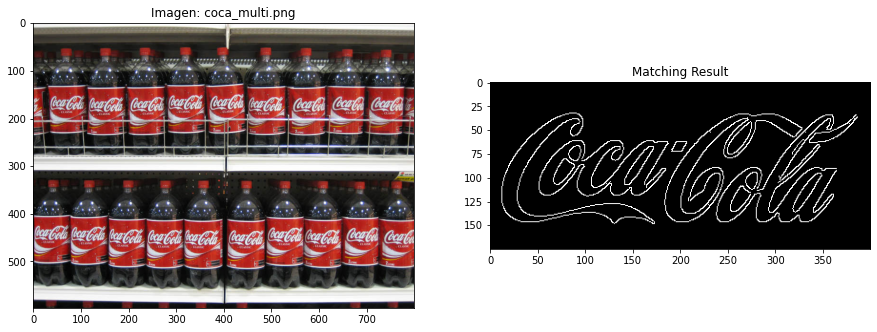

In [108]:
img_rgb = cv.imread('./images/coca_multi.png')
img_rgb = cv.cvtColor(img_rgb, cv.COLOR_BGR2RGB)
img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
image_vs_template(img_rgb, 'coca_multi.png', template)

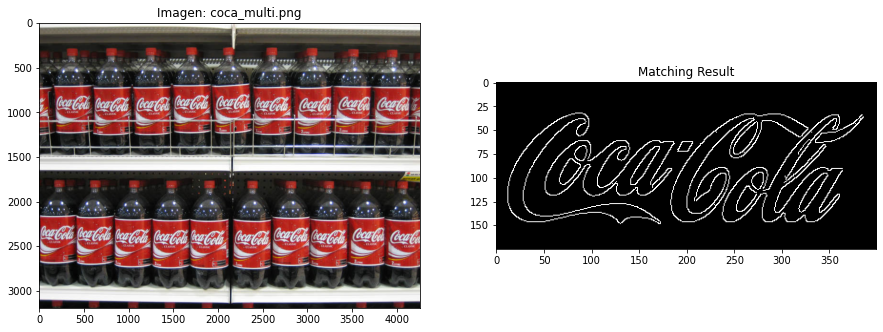

In [116]:
img_resized, template_resized = scale_size(img_rgb, template, 75)
image_vs_template(img_resized, 'coca_multi.png', template_resized)

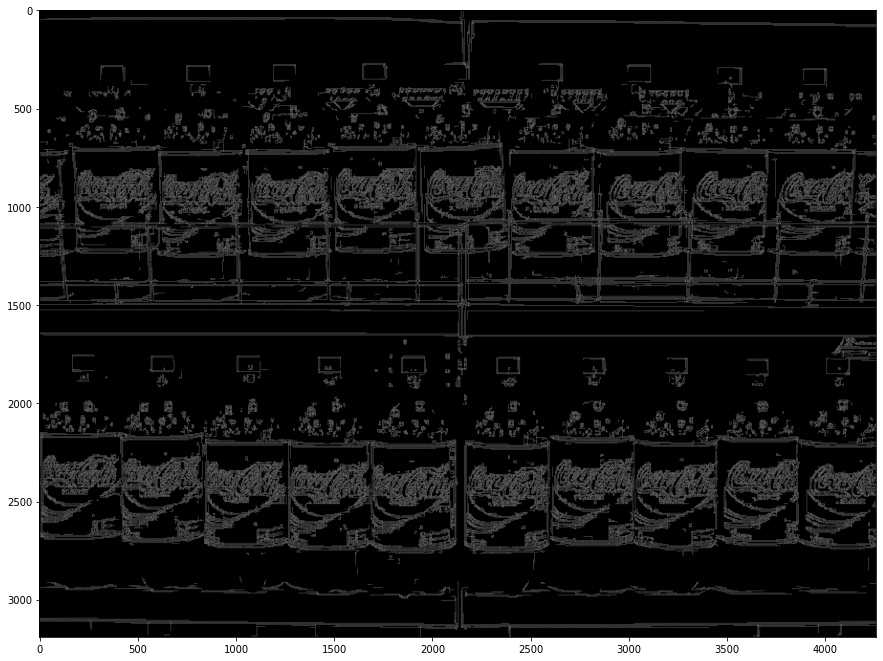

In [110]:
img_resized_canny = cv.Canny(img_resized, 85, 200)
plt.figure(figsize=(15,15))
plt.imshow(img_resized_canny, cmap='gray')
plt.show()

In [ ]:
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']

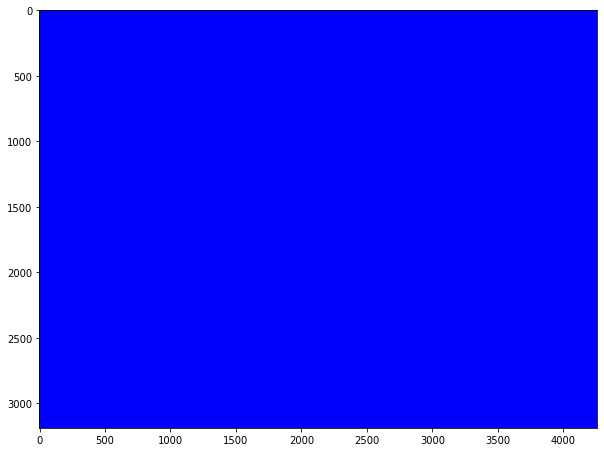

In [117]:
img_gray = cv.cvtColor(img_resized, cv.COLOR_BGR2GRAY)

w, h = template_resized.shape[::-1]
res = cv.matchTemplate(img_gray, template_resized, cv.TM_CCORR)

# Fijamos un umbral de "coincidencia"
threshold = 0.95
loc = np.where(res>=threshold)
for pt in zip(*loc[::-1]):
    cv.rectangle(img_resized, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

plt.figure(figsize=(10,10))
plt.imshow(img_resized)
plt.show()